# k-Means

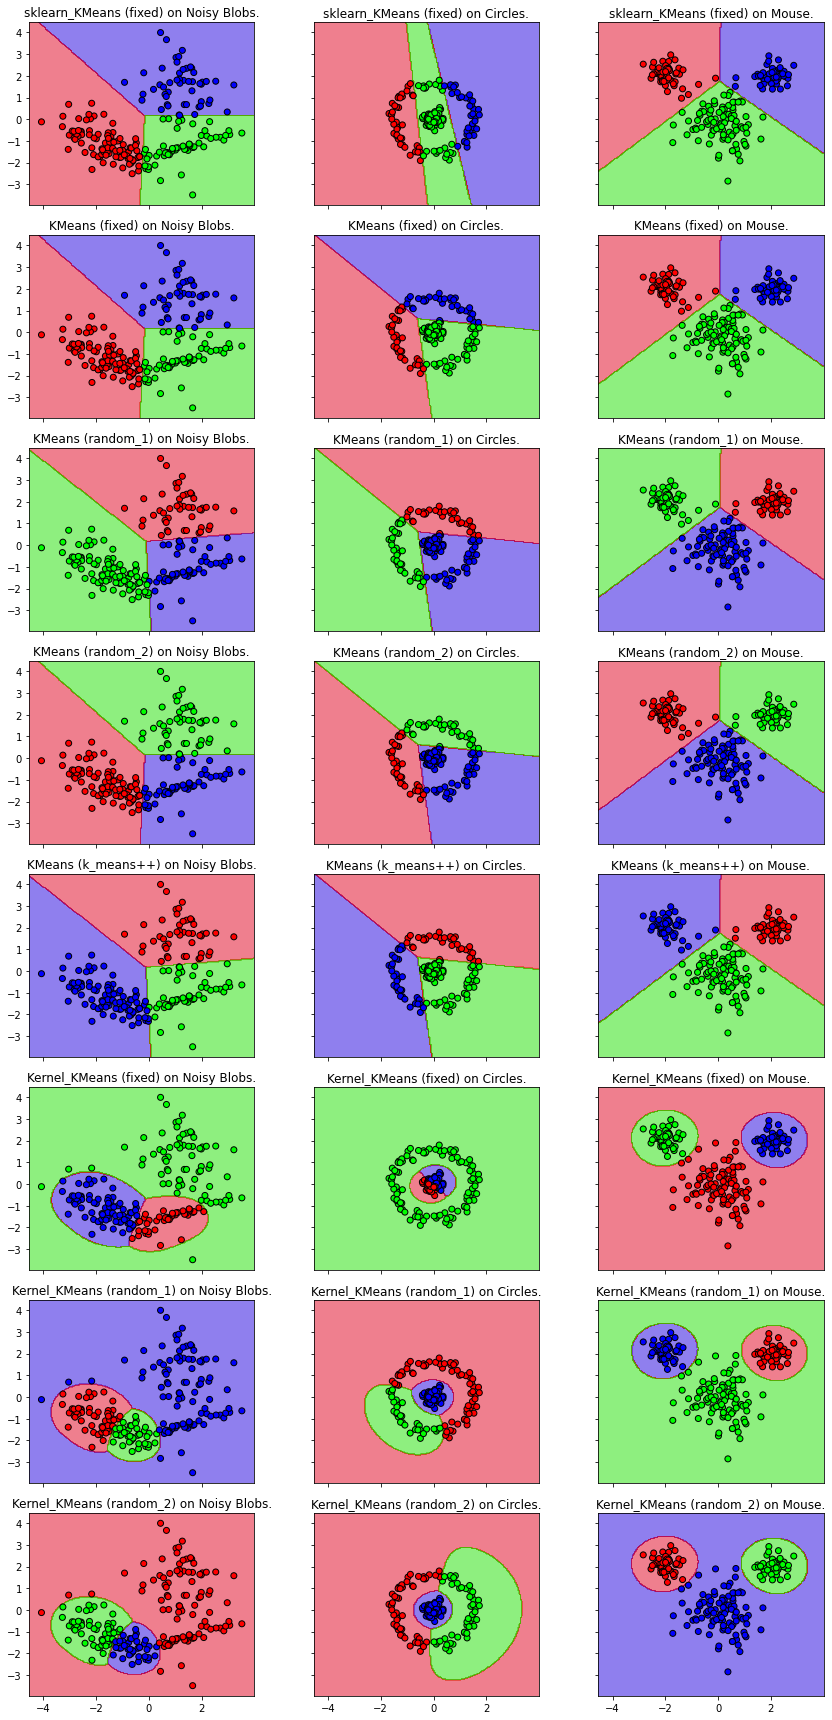

Wall time: 2min


In [1]:
%%time

# Implementation of k-Means and kernel k-Means algorithms for clustering/classification problem
# Comparison of the correctness of the algorithms with sklearn.
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from sklearn.datasets import make_classification, make_circles, make_blobs
from sklearn.cluster import KMeans, DBSCAN
from sklearn.base import BaseEstimator
import warnings
warnings.filterwarnings("ignore")

# k-means
class K_Means(BaseEstimator):
    def __init__(self, k, initial_centroids='random', max_iter=300):
        super(K_Means, self).__init__()
        
        self.k = k
        self.initial_centroids = initial_centroids
        self.max_iter = max_iter
        
    def fit(self, X):
        if self.initial_centroids == "random":
            self.initial_centroids = [X[i] for i in np.random.choice(X.shape[0], size= self.k)]
        if self.initial_centroids == "kmeans++":
            self.initial_centroids = [X[np.random.choice(X.shape[0], size= self.k)[0]]]
            for c_id in range(self.k - 1):
                dist =[]
                for features in X:
                    distances=[np.linalg.norm(features-centroid) for centroid in self.initial_centroids]
                    dist.append(min(distances))
                dist = np.array(dist) 
                next_centroid = X[np.argmax(dist), :]
                self.initial_centroids.append(next_centroid)
            
        for i in range(self.max_iter):
            self.classes={}
            for i in range(self.k):
                self.classes[i]=[]
            for features in X:
                distances=[np.linalg.norm(features-centroid) for centroid in self.initial_centroids]
                classification=distances.index(min(distances))
                self.classes[classification].append(features)
            previous=dict(self.initial_centroids)
            for classification in self.classes:
            	self.initial_centroids[classification] = np.average(self.classes[classification], axis = 0)

    def predict(self, X):
        classifications = []
        for features in X:
            distances = [np.linalg.norm(features - centroid) for centroid in self.initial_centroids]
            classifications.append(distances.index(min(distances)))
        return np.array(classifications)
    
    def fit_predict(self, X):
        self.fit(X)
        return self.predict(X)

# kernel k-Means
class Kernel_K_Means(BaseEstimator):
    def __init__(self, k, kernel_func, initial_assignment="random", max_iter=300, sigma = 0.7):
        super(Kernel_K_Means, self).__init__()
        
        self.k = k
        self.initial_assignment = initial_assignment
        self.max_iter = max_iter
        self.kernel_func = kernel_func
        self.sigma = sigma
    
    def compute_RBF(self, mat1, mat2, sigma):
        mat1 = np.mat(mat1)
        mat2 = np.mat(mat2)
        trnorms1 = np.mat([(v * v.T)[0, 0] for v in mat1]).T
        trnorms2 = np.mat([(v * v.T)[0, 0] for v in mat2]).T
        k1 = trnorms1 * np.mat(np.ones((mat2.shape[0], 1), dtype=np.float64)).T
        k2 = np.mat(np.ones((mat1.shape[0], 1), dtype=np.float64)) * trnorms2.T
        k = k1 + k2
        k -= 2 * np.mat(mat1 * mat2.T)
        k *= - 1./(2 * np.power(sigma, 2))
        return np.array(np.exp(k))
    
    def compute_dist(self, K, dist, within_distances, update_within):
        sample_weights = self.sample_weight

        for i in range(self.k):
            mask = self.labels == i
            
            mul = sample_weights[mask].sum()
            mulsq = mul*mul
            
            if update_within:
                KK = K[mask][:,mask]
                dist_i = np.sum(np.outer(sample_weights[mask],sample_weights[mask]) * KK / mulsq)
                within_distances[i] = dist_i
                dist[:,i] += dist_i
            else:
                dist[:,i] += within_distances[i]
            
            dist[:,i] -= 2*np.sum(sample_weights[mask] * K[:,mask], axis = 1) / mul
            
        
    def fit(self, X):
        n_samples = X.shape[0]
        if self.kernel_func == "RBF":
            K = self.compute_RBF(X, X, self.sigma)
        if (self.initial_assignment == "random"):
            self.labels = np.random.choice(range(self.k),size=n_samples, replace=True)
        else:
            self.labels = self.initial_assignment            
            
        sample_weights = np.ones(n_samples)
        self.sample_weight = sample_weights
        dist = np.zeros((n_samples,self.k))
        self.within_distances = np.zeros(self.k)
        
        for i in range(self.max_iter):
            dist.fill(0)
            self.compute_dist(K,dist, self.within_distances, update_within = True)
            labels_old = self.labels
            self.labels = dist.argmin(axis=1)
            n_same = np.sum((self.labels - labels_old) == 0)
            if 1 - float(n_same) / n_samples < 1e-4:
                break
        self.X_fit_ = X
        return self
        
    def predict(self, X):
        K = self.compute_RBF(X, self.X_fit_,self.sigma)
        n_samples = X.shape[0]
        dist = np.zeros((n_samples, self.k))
        self.compute_dist(K, dist, self.within_distances,
                           update_within=False)
        return np.argmin(dist, axis=1)
    
    def fit_predict(self, X):
        self.fit(X)
        return self.predict(X)


# Generate toy data
def generate_data():
    n = 200
    n_classes = 3
    X, Y = make_classification(n, n_features=2, n_redundant=0, n_classes=n_classes, weights=(0.5, 0.3, 0.2),
                               class_sep=1.3, n_clusters_per_class=1, random_state=12345)
    yield ('Noisy Blobs', X)
    
    X, Y = make_circles(n, noise=0.08, factor=0.1, random_state=1234)
    yield ('Circles', X*1.6)
    
    X, Y = make_blobs([n//2, n//4, n//4], n_features=2, centers=[[0, 0], [-2, 2], [2, 2]],
                               cluster_std=[0.8, 0.35, 0.35], random_state=1234)
    yield ('Mouse', X)
datasets = list(generate_data())

initial_c = np.array([[ 1.57747042,  0.04248975],
                      [-1.38669281, -0.45473879],
                      [ 0.28039302, -0.2942349 ]])
initial_a = np.array([0, 2, 2, 0, 1, 0, 2, 0, 1, 2, 1, 0, 2, 0, 2, 1, 0, 1, 1, 0, 1, 0, 2, 1, 0,
                      2, 2, 1, 0, 1, 2, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 2, 0, 1, 2, 2, 2, 2, 1, 1,
                      1, 2, 1, 1, 2, 2, 1, 0, 2, 2, 2, 2, 0, 1, 2, 2, 0, 2, 2, 1, 2, 1, 0, 2, 0,
                      1, 0, 2, 0, 2, 2, 2, 1, 1, 1, 1, 1, 2, 1, 0, 0, 2, 2, 2, 2, 0, 0, 1, 1, 2,
                      1, 2, 0, 2, 1, 2, 0, 0, 2, 0, 2, 0, 2, 1, 1, 2, 0, 0, 1, 2, 1, 2, 1, 0, 0,
                      2, 1, 2, 1, 0, 2, 2, 2, 1, 1, 1, 0, 2, 0, 2, 2, 0, 0, 0, 1, 2, 1, 2, 2, 2,
                      2, 2, 1, 1, 1, 0, 0, 2, 0, 1, 1, 1, 1, 1, 0, 2, 2, 1, 1, 1, 0, 1, 0, 0, 2,
                      1, 2, 0, 1, 0, 0, 2, 2, 0, 1, 0, 1, 1, 1, 0, 2, 0, 1, 2, 0, 1, 0, 2, 1, 0])

# Testing all implementation
clusterers = [('sklearn_KMeans (fixed)', KMeans(n_clusters=3, init=initial_c, n_init=1)),
              ('KMeans (fixed)', K_Means(k=3, initial_centroids=initial_c)),
              ('KMeans (random_1)', K_Means(k=3, initial_centroids='random')),
              ('KMeans (random_2)', K_Means(k=3, initial_centroids='random')),
              ('KMeans (k_means++)', K_Means(k=3, initial_centroids='kmeans++')),
              ('Kernel_KMeans (fixed)', Kernel_K_Means(k=3, kernel_func = "RBF",initial_assignment=initial_a)),
              ('Kernel_KMeans (random_1)', Kernel_K_Means(k=3, kernel_func = "RBF")),
              ('Kernel_KMeans (random_2)', Kernel_K_Means(k=3, kernel_func = "RBF")),
             ]

# Plot decision surface
# First generate grid
res = 200  # Resolution of the grid in cells
x_max, y_max = np.max(np.stack([np.max(X, axis=0) for _, X in datasets]), axis=0)
x_min, y_min = np.min(np.stack([np.min(X, axis=0) for _, X in datasets]), axis=0)
x_min, x_max = x_min - (x_max - x_min) * 0.0625, x_max + (x_max - x_min) * 0.0625
y_min, y_max = y_min - (y_max - y_min) * 0.0625, y_max + (y_max - y_min) * 0.0625
grid_x, grid_y = np.meshgrid(np.linspace(x_min, x_max, res),
                             np.linspace(y_min, y_max, res))
# Get test array from grid
grid_input = np.c_[grid_x.reshape(-1), grid_y.reshape(-1)]

cmap = colors.ListedColormap([[0.0, 0.0, 1.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 0.0]])
rows = len(clusterers)
columns = len(datasets)
fig, axes = plt.subplots(rows, columns, sharex=True, sharey=True, figsize=(12, 9/columns*rows), squeeze=False)
for (clu_name, clu), row_axes in zip(clusterers, axes):
    for (ds_name, X), ax in zip(datasets, row_axes):
        clusters = clu.fit_predict(X)
        if hasattr(clu, 'predict'):
            grid_out = clu.predict(grid_input).reshape(grid_x.shape)
            ax.contourf(grid_x, grid_y, grid_out%4, alpha=0.5, cmap=plt.cm.brg, vmin=0, vmax=2)
        ax.set(xlim=(x_min, x_max), ylim=(y_min, y_max))

        ax.set_title(f'{clu_name:s} on {ds_name:s}.')
        ax.scatter(X[:, 0], X[:, 1], c=cmap(clusters%4), edgecolor='k')
fig.tight_layout()
fig.savefig('kmeans_plots.pdf')
plt.show()
plt.close(fig)